In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("estimation")
    axs[1].imshow(plotable(x_hat))
    plt.show()

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "mnist/vae/langevin/inpainting"
config = get_model_config(model_name)
config["exp_params"]["batch_size"] = 100
dm = mnist_dataloader_test(config, path=path)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Inpainting 

In [3]:
config["operator_params"]["operator"] = "RandomOcclude"

## MAP initalisation

In [6]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [7]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

100%|██████████| 15/15 [07:33<00:00, 30.26s/it]


## Random

In [8]:
config["estimator_params"]["initalisation"] = "random"

In [9]:
random = []
error_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

100%|██████████| 15/15 [01:21<00:00,  5.45s/it]


## DWLS-random

In [10]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "random"

In [11]:
dwls_random = []
error_dwls_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_random.append(e_x)
    error_dwls_random.append(std)

100%|██████████| 15/15 [03:23<00:00, 13.56s/it]


## DWLS-map

In [12]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [13]:
dwls_map = []
error_dwls_map = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_map.append(e_x)
    error_dwls_map.append(std)

 40%|████      | 6/15 [03:50<05:45, 38.43s/it]

In [ ]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

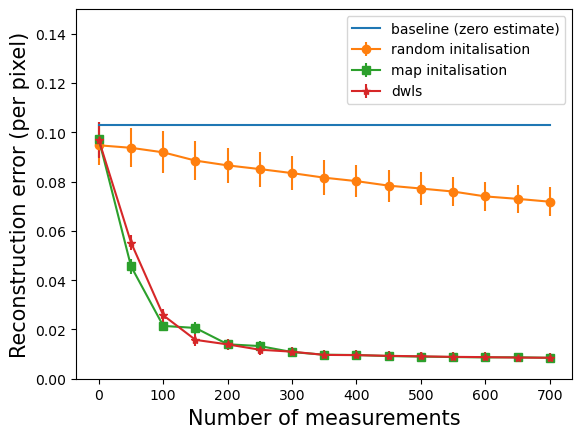

In [ ]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), random, yerr=error_random, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), dwls_random, yerr=error_dwls_random, fmt='-^')
plt.errorbar(list(range(0, 750, 50)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.errorbar(list(range(0, 750, 50)), dwls_map, yerr=error_dwls_map, fmt='-*')
plt.legend(['baseline (zero estimate)','random initalisation', "dwls_random", 'map initalisation', "dwls_map_initalisaiton"])
plt.show()

# Compressed Sensing

In [ ]:
config["operator_params"]["operator"] = "CompressedSensing"
config["operator_params"]["num_measurements"] = 200
config['estimator_params']['lambda'] = 1
config['estimator_params']['potential'] = "mse"
config["base_model_params"]["base_model"] = "vae"

## Random

In [ ]:
config["estimator_params"]["initalisation"] = "random"

In [ ]:
random = []
error_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

## MAP-initalisation

In [ ]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [ ]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

## dwls-random

In [ ]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "random"

In [ ]:
dwls_random = []
error_dwls_random = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_random.append(e_x)
    error_dwls_random.append(std)

## dwls-map-posterior

In [ ]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [ ]:
dwls_map = []
error_dwls_map = []
for num in trange(0, 750, 50):
    config["operator_params"]["num_measurements"] = num
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_map.append(e_x)
    error_dwls_map.append(std)

In [ ]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

In [ ]:
plt.xlabel('Number of measurements', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
plt.plot(list(range(0, 750, 50)), [baseline]*15)
plt.errorbar(list(range(0, 750, 50)), random, yerr=error_random, fmt='-o')
plt.errorbar(list(range(0, 750, 50)), dwls_random, yerr=error_dwls_random, fmt='-^')
plt.errorbar(list(range(0, 750, 50)), map_posterior, yerr=error_map_posterior, fmt='-s')
plt.errorbar(list(range(0, 750, 50)), dwls_map, yerr=error_dwls_map, fmt='-*')
plt.legend(['baseline (zero estimate)','random initalisation', "dwls_random", 'map initalisation', "dwls_map_initalisaiton"])
plt.show()

# Denoising

In [ ]:
config["operator_params"]["operator"] = "GuassianNoise"
config["operator_params"]["noise_level"] = 0.5

## Random

In [ ]:
config["estimator_params"]["initalisation"] = "random"

In [ ]:
random = []
error_random = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    random.append(e_x)
    error_random.append(std)

## MAP-posterior

In [ ]:
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [ ]:
map_posterior = []
error_map_posterior = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    emb = ebm.to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    map_posterior.append(e_x)
    error_map_posterior.append(std)

## DWLS-random

In [ ]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "random"

In [ ]:
dwls_random = []
error_dwls_random = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_random.append(e_x)
    error_dwls_random.append(std)

## DWLS-map-initalisation

In [ ]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['lambda'] = 500
config['estimator_params']['lambda_score'] = 1
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 100
config["estimator_params"]["step_size_map_initaliser"] = 0.1

In [ ]:
dwls_map = []
error_dwls_map = []
for num in trange(0, 16):
    config["operator_params"]["noise_level"] = num/15
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    ebm.kwargs["discriminator"].to("cuda")
    error = []
    for x, y in dm:
        x = x.to("cuda")
        x_tilde = ebm.operator(x)
        x_hat = ebm(x_tilde)
        error.append(reconstruction_error(x_hat, x))
    e_x = (sum(error)/len(error)).cpu().detach()
    e_x2 = (sum(map(lambda x: x**2, error))/len(error)).cpu().detach()
    std = np.sqrt(e_x2 - (e_x)**2)
    dwls_map.append(e_x)
    error_dwls_map.append(std)

In [ ]:
error = []
for x, y in dm:
    x = x.to("cuda")
    error.append(reconstruction_error(torch.zeros_like(x), x))
baseline = (sum(error)/len(error)).cpu().detach()

In [ ]:
plt.xlabel('Noise Level', fontsize=15)
plt.ylabel('Reconstruction error (per pixel)', fontsize=15)
plt.ylim(0, 0.15)
noise = [i/15.0 for i in range(0, 16)]
plt.plot(noise, [baseline]*16)
plt.errorbar(noise, random, yerr=error_random, fmt='-o')
plt.errorbar(noise, random, dwls_random, yerr=error_dwls_random, fmt='-^')
plt.errorbar(noise, map_posterior, yerr=error_map_posterior, fmt='-s')
plt.errorbar(noise, dwls_map, yerr=error_dwls_map, fmt='-*')
plt.legend(['baseline (zero estimate)','random initalisation', "dwls_random", 'map initalisation', "dwls_map_initalisaiton"])
plt.show()